# Using Variational Autoencoder and Deep Feature Loss to Generate Faces

From the "Using Variational Autoencoder to Generate Faces" example, we see that using VAE, we can generate realistic human faces, but the generated image is a little blury. Though, you can continue to tuning the hyper paramters or using more data to get a better result, in this example, we adopted the approach in [this paper](https://arxiv.org/abs/1610.00291). That is, instead of using pixel-by-pixel loss of between the original images and the generated images, we use the feature map generated by a pre-trained CNN network to define a feature perceptual loss. As you will see, the generated images will become more vivid.

In [1]:
from bigdl.nn.layer import *
from bigdl.nn.criterion import *
from bigdl.optim.optimizer import *
from bigdl.dataset import mnist
import datetime as dt
from bigdl.util.common import *
from glob import glob
import os
import scipy.misc
import numpy as np
from utils import *

image_size = 148
Z_DIM = 100
ENCODER_FILTER_NUM = 32
DATA_PATH = "/tmp/celeba/img_align_celeba"

init_engine()

## Define the Model

We are uing the same model as "Using Variational Autoencoder to Generate Faces" example.

In [2]:
def conv_bn_lrelu(in_channels, out_channles, kw=4, kh=4, sw=2, sh=2, pw=-1, ph=-1):
    model = Sequential()
    model.add(SpatialConvolution(in_channels, out_channles, kw, kh, sw, sh, pw, ph))
    model.add(SpatialBatchNormalization(out_channles))
    model.add(LeakyReLU(0.2))
    return model

def upsample_conv_bn_lrelu(in_channels, out_channles, out_width, out_height, kw=3, kh=3, sw=1, sh=1, pw=-1, ph=-1):
    model = Sequential()
    model.add(ResizeBilinear(out_width, out_height))
    model.add(SpatialConvolution(in_channels, out_channles, kw, kh, sw, sh, pw, ph))
    model.add(SpatialBatchNormalization(out_channles))
    model.add(LeakyReLU(0.2))
    return model

In [3]:
def get_encoder_cnn():
    input0 = Input()
    
    #CONV
    conv1 = conv_bn_lrelu(3, ENCODER_FILTER_NUM)(input0) # 32 * 32 * 32
    conv2 = conv_bn_lrelu(ENCODER_FILTER_NUM, ENCODER_FILTER_NUM*2)(conv1) # 16 * 16 * 64
    conv3 = conv_bn_lrelu(ENCODER_FILTER_NUM*2, ENCODER_FILTER_NUM*4)(conv2) # 8 * 8 * 128
    conv4 = conv_bn_lrelu(ENCODER_FILTER_NUM*4, ENCODER_FILTER_NUM*8)(conv3) # 4 * 4 * 256
    view = View([4*4*ENCODER_FILTER_NUM*8])(conv4)
    
    # fully connected to generate mean and log-variance
    mean = Linear(4*4*ENCODER_FILTER_NUM*8, Z_DIM)(view)
    log_variance = Linear(4*4*ENCODER_FILTER_NUM*8, Z_DIM)(view)
    
    model = Model([input0], [mean, log_variance])
    return model

In [4]:
def get_decoder_cnn():
    input0 = Input()
    
    linear = Linear(Z_DIM, 4*4*ENCODER_FILTER_NUM*8)(input0)
    reshape = Reshape([ENCODER_FILTER_NUM*8, 4, 4])(linear)
    bn = SpatialBatchNormalization(ENCODER_FILTER_NUM*8)(reshape)
    
    # upsampling
    up1 = upsample_conv_bn_lrelu(ENCODER_FILTER_NUM*8, ENCODER_FILTER_NUM*4, 8, 8)(bn) # 8 * 8 * 128
    up2 = upsample_conv_bn_lrelu(ENCODER_FILTER_NUM*4, ENCODER_FILTER_NUM*2, 16, 16)(up1) # 16 * 16 * 64
    up3 = upsample_conv_bn_lrelu(ENCODER_FILTER_NUM*2, ENCODER_FILTER_NUM, 32, 32)(up2) # 32 * 32 * 32
    up4 = upsample_conv_bn_lrelu(ENCODER_FILTER_NUM, 3, 64, 64)(up3) # 64 * 64 * 3
    output = Tanh()(up4)
    
    model = Model([input0], [output])
    return model

In [5]:
def get_autoencoder_cnn():
    input0 = Input()
    encoder = get_encoder_cnn()(input0)
    sampler = GaussianSampler()(encoder)
    
    decoder_model = get_decoder_cnn()
    decoder = decoder_model(sampler)
    
    model = Model([input0], [encoder, decoder])
    return model, decoder_model

## Load the pre-trained CNN model

In [6]:
def get_vgg():
    # we use the vgg16 model, it should work on other popular CNN models
    # You can download them here (https://github.com/intel-analytics/analytics-zoo/tree/master/models)
    vgg_whole = Model.from_jvalue(Model.loadModel("/tmp/bigdl/vgg16.bigdl").value)

    # we only use one feature map here for the sake of simlicity and efficiency
    # You can and other feature to the outputs to mix high-level and low-level
    # feature to get higher quality images
    outputs = [vgg_whole.node(name) for name in ["relu1_2"]]
    inputs = [vgg_whole.node(name) for name in ["data"]]
    
    outputs[0].remove_next_edges()

    vgg_light = Model(inputs, outputs).freeze()
    
    return vgg_light
    

In [7]:
vgg = get_vgg()

creating: createModel


In [8]:
model, decoder = get_autoencoder_cnn()

creating: createInput
creating: createInput
creating: createSequential
creating: createSpatialConvolution
creating: createSpatialBatchNormalization
creating: createLeakyReLU
creating: createSequential
creating: createSpatialConvolution
creating: createSpatialBatchNormalization
creating: createLeakyReLU
creating: createSequential
creating: createSpatialConvolution
creating: createSpatialBatchNormalization
creating: createLeakyReLU
creating: createSequential
creating: createSpatialConvolution
creating: createSpatialBatchNormalization
creating: createLeakyReLU
creating: createView
creating: createLinear
creating: createLinear
creating: createModel
creating: createGaussianSampler
creating: createInput
creating: createLinear
creating: createReshape
creating: createSpatialBatchNormalization
creating: createSequential
creating: createResizeBilinear
creating: createSpatialConvolution
creating: createSpatialBatchNormalization
creating: createLeakyReLU
creating: createSequential
creating: create

## Load the Datasets

In [9]:
def get_data():
    data_files = glob(os.path.join(DATA_PATH, "*.jpg"))
    
    rdd_train_images = sc.parallelize(data_files[:100000]) \
                              .map(lambda path: get_image(path, image_size).transpose(2, 0, 1))

    rdd_train_sample = rdd_train_images.map(lambda img: Sample.from_ndarray(img, [np.array(0.0), img]))
    return rdd_train_sample

In [10]:
train_data = get_data()

## Define the Training Objective

In [11]:
criterion = ParallelCriterion()
criterion.add(KLDCriterion(), 0.005) # You may want to twick this parameter
criterion.add(TransformerCriterion(MSECriterion(), vgg, vgg), 1.0)

creating: createParallelCriterion
creating: createKLDCriterion
creating: createMSECriterion
creating: createTransformerCriterion


## Define the Optimizer

In [12]:
batch_size = 64


# Create an Optimizer
optimizer = Optimizer(
    model=model,
    training_rdd=train_data,
    criterion=criterion,
    optim_method=Adam(0.0005),
    end_trigger=MaxEpoch(1),
    batch_size=batch_size)


app_name='vae-'+dt.datetime.now().strftime("%Y%m%d-%H%M%S")
train_summary = TrainSummary(log_dir='/tmp/vae',
                                     app_name=app_name)


optimizer.set_train_summary(train_summary)

print "saving logs to ",app_name

creating: createAdam
creating: createMaxEpoch
creating: createDistriOptimizer
creating: createTrainSummary
saving logs to  vae-20180123-185746


## Spin Up the Training

This could take a while. It took about 6 hours on a desktop with a intel i7-6700 cpu and 40GB java heap memory. You can reduce the training time by using less data (some changes in the "Load the Dataset" section), but the performce may not as good.

In [13]:
redire_spark_logs()
show_bigdl_info_logs()

In [14]:
def gen_image_row():
    decoder.evaluate()
    return np.column_stack([decoder.forward(np.random.randn(1, Z_DIM)).reshape(3, 64,64).transpose(1, 2, 0) for s in range(8)])

def gen_image():
    return inverse_transform(np.row_stack([gen_image_row() for i in range(8)]))

In [15]:
for i in range(1, 16):
    optimizer.set_end_when(MaxEpoch(i))
    trained_model = optimizer.optimize()
    image = gen_image()
    # you may change the following directory accordingly and make sure the directory
    # you are writing to exists
    scipy.misc.imsave("./images/image_%s.png" % i , image)
    decoder.saveModel("./models/decoder_%s.model" % i, over_write = True)

creating: createMaxEpoch
creating: createMaxEpoch
creating: createMaxEpoch
creating: createMaxEpoch
creating: createMaxEpoch
creating: createMaxEpoch
creating: createMaxEpoch
creating: createMaxEpoch
creating: createMaxEpoch
creating: createMaxEpoch
creating: createMaxEpoch
creating: createMaxEpoch
creating: createMaxEpoch
creating: createMaxEpoch
creating: createMaxEpoch


In [16]:
import matplotlib
matplotlib.use('Agg')
%pylab inline

import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


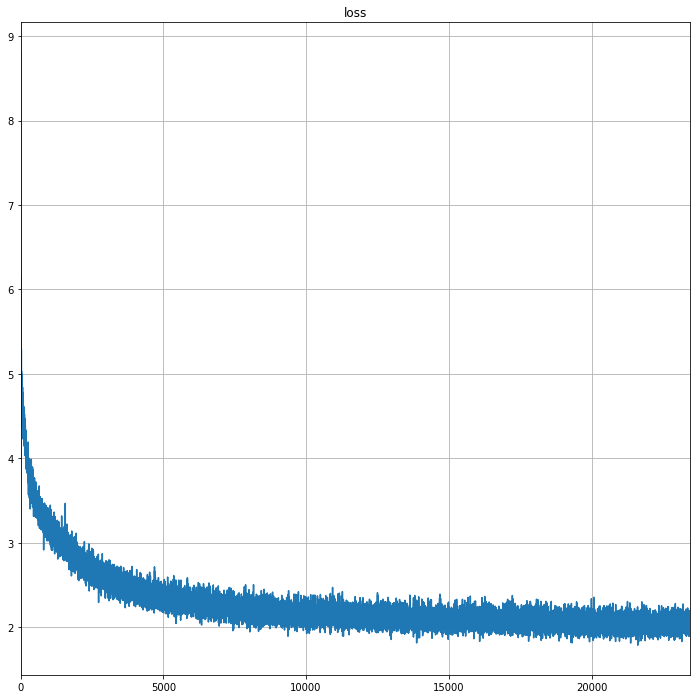

In [17]:
loss = np.array(train_summary.read_scalar("Loss"))

plt.figure(figsize = (12,12))
plt.plot(loss[:,0],loss[:,1],label='loss')
plt.xlim(0,loss.shape[0]+10)
plt.grid(True)
plt.title("loss")

## Random Sample Some Images

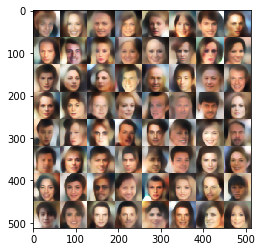

In [20]:
from matplotlib.pyplot import imshow
img = gen_image()
imshow(img)